# Investating and Improving Movie Production

Movies have been being produced for 127 years, lending itself to a massive collection of data associated with those movies. It is in the best interest of Computing Vision to follow these guidelines in order to produce movies of a higher quality that produce higher net profit.

Based on the data collected by `IMDB`, `The Numbers`, `The Movie Data Base`, and `Box Office Mojo`, we are able to determine that there are three major areas of interest that Computing Vision should focus on in order to maximize profits of their newly created content. The top three metrics are as follows:
* Release Month
* Director
* Writer

We will be diving into Release month and its impact on net profit. Before we can do that there are some standard modules that we will use to demonstrate the impact of these metrics.

In [19]:
import pandas as pd
import sqlite3
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_1samp
import calendar

conn = sqlite3.connect('data/im.db')

## Release Month
If we aggregate data from `The Numbers` database we can determine which months have the movies that average the most profit.

### Step 1 - Pull the data from the database

In [20]:
month_agg_data = pd.read_sql("""
SELECT SUBSTR(release_date, 0, 4) as month, AVG(worldwide_gross - production_budget) as mean_net_profit
FROM movie_budgets
GROUP BY month
ORDER BY mean_net_profit DESC;
""", conn)
month_agg_data

,month,mean_net_profit
0,May,1.151328e+08
1,Jun,9.942391e+07
2,Jul,9.841746e+07
3,Nov,9.314157e+07
4,Dec,6.844157e+07
5,Mar,4.985129e+07
6,Feb,4.349811e+07
7,Apr,3.611743e+07
8,Aug,3.542232e+07
9,Oct,2.907190e+07


### Step 2 - Displaying the Aggregated Data
From this we can see that releasing movies during the summer months will generally see a higher profit than releasing movies during the back to school season or January after Christmas break. We can show this with a bar plot indicating the relative average net profit.

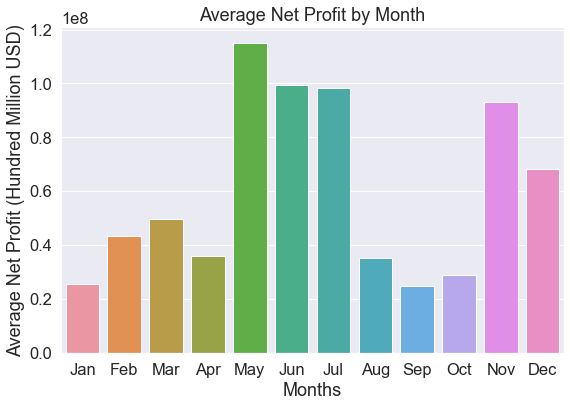

In [21]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_agg_data['month'] = pd.Categorical(month_agg_data['month'], categories=months, ordered=True)
cols = ['green' if (val > 94000000) else 'red' for val in month_agg_data.mean_net_profit]

sns.set(rc={
    'figure.figsize':(9,6)
    })
sns.set(font_scale=1.5)
barplot = sns.barplot(
    data = month_agg_data, 
    x='month', 
    y='mean_net_profit',
    palette=cols
    )
barplot.set(
    xlabel='Months', 
    ylabel='Average Net Profit (Hundred Million USD)', 
    title='Average Net Profit by Month'
    );

### Step 3 Generating Non-Aggregated Data
In order to further investigate whether or not the samples we've gather here actually represent a fluctuation in the average net profit for the entire population, we must conduct an ANOVA test in order to reject the null hypothesis that the population mean for `May` is in fact significantly different than the population mean for `September`. In order to perform this test we need non-aggregated data for each of the 12 months.

In [22]:
month_data = pd.read_sql("""
SELECT SUBSTR(release_date, 0, 4) as month, (worldwide_gross - production_budget) as net_profit
FROM movie_budgets;
""", conn)
month_data

,month,net_profit
0,Dec,2351345279
1,May,635063875
2,Jun,-200237650
3,May,1072413963
4,Dec,999721747
...,...,...
5777,Dec,-7000
5778,Apr,234495
5779,Jul,-3662
5780,Sep,-1400


With this data we can use the scipy module to perform an ANOVA test that shows whether or not there is a significant difference between the population means of the categorical variables.

In [23]:
#include ttest_1samp with may/sep and pop mean

jan = month_data[month_data.month == 'Jan'].net_profit
feb = month_data[month_data.month == 'Feb'].net_profit
mar = month_data[month_data.month == 'Mar'].net_profit
apr = month_data[month_data.month == 'Apr'].net_profit
may = month_data[month_data.month == 'May'].net_profit
jun = month_data[month_data.month == 'Jun'].net_profit
jul = month_data[month_data.month == 'Jul'].net_profit
aug = month_data[month_data.month == 'Aug'].net_profit
sep = month_data[month_data.month == 'Sep'].net_profit
oct = month_data[month_data.month == 'Oct'].net_profit
nov = month_data[month_data.month == 'Nov'].net_profit
dec = month_data[month_data.month == 'Dec'].net_profit

f_oneway(jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec)

F_onewayResult(statistic=24.453383228456943, pvalue=4.995036106067499e-50)

In [24]:
ttest_1samp(may, month_data.net_profit.mean())

Ttest_1sampResult(statistic=5.3698748782509265, pvalue=1.32901576115874e-07)

With a miniscule p value, we can with confidence reject the null hypothesis and conclude that there is in fact a significant difference between the population means of the different groups, indicating that there is merit to releasing movies during the summer months as opposed to months such as September or January. With an additional t_test between the month of May and the population mean we can also determine with certainty that there is a significant difference between the month of May and the rest of the months.

## Director

In this notebook we are testing to find a correlation between director and mean_net_profit This code was worked on by Walter Friedrich and Aidan Ryan

Imports and SQL data connection

Aggregated SQL query

Top 10 directors with highest mean_net_profit with num_movies greater than 5
Ordered by highest mean_net_profit descending

In [25]:
director_AGG = pd.read_sql("""
SELECT pe.primary_name as director, AVG(mob.worldwide_gross - mob.production_budget) as mean_net_profit, COUNT(pe.primary_name) as num_movies
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'director'
GROUP BY pe.primary_name
HAVING num_movies > 5
ORDER BY mean_net_profit DESC
LIMIT 10
;
""", conn)
director_AGG

,director,mean_net_profit,num_movies
0,Tim Burton,1.908611e+08,6
1,Ridley Scott,1.769673e+08,7
2,Steven Spielberg,1.647550e+08,8
3,Jon M. Chu,1.502429e+08,6
4,Clint Eastwood,1.379160e+08,6
5,Jaume Collet-Serra,7.547862e+07,6
6,Denis Villeneuve,5.732786e+07,6
7,Tim Story,4.845786e+07,9
8,Steven Soderbergh,4.558173e+07,7
9,David Gordon Green,4.236483e+07,8


Disaggregated SQL query 2 categories
Director
net_profit

In [26]:
director = pd.read_sql("""
SELECT pe.primary_name as director, AVG(mob.worldwide_gross - mob.production_budget) as mean_net_profit
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'director'
GROUP BY pe.primary_name
ORDER BY mean_net_profit DESC
;
""", conn)
director

,director,mean_net_profit
0,Atsushi Wada,2.351345e+09
1,Ravi Punj,2.008208e+09
2,Jennifer Lee,1.122470e+09
3,Chris Buck,1.122470e+09
4,Chi-kin Kwok,1.122470e+09
...,...,...
2982,Daniel Beard,-7.944858e+07
2983,Candy J. Beard,-7.944858e+07
2984,Bambang Drias,-7.944858e+07
2985,Simon Wells,-1.104502e+08


Our goal is to gain a deeper understanding of the statistics underlying our sample population, with a particular focus on identifying any significant differences between two groups, namely the directors and mean net profits. We aim to test our hypothesis that directors make a significantly higher net profit than the population mean, while rejecting the null hypothesis that they do not.

Hypothesis: (Director) makes significantly more net profit than our population mean.

Null Hypothesis: (Director) does not make significantly more net profit than our population mean.

The formula for the t-test is as follows:


In [27]:
population_mean = director['mean_net_profit'].mean()

t_test = ttest_1samp(director_AGG['mean_net_profit'], population_mean)

print(t_test)

Ttest_1sampResult(statistic=3.0524821410893903, pvalue=0.013737634342785918)


The t-test statistic of 2.2198435887264623 suggests that there is a statistically significant difference between the sample mean and the population mean. This means that it is unlikely that the difference between the sample mean and the population mean is due to chance. The exact interpretation of this result would depend on the specific research question and hypothesis being tested.

Sample mean of mean net profit: 108995329.64623013 Sample standard deviation of mean net profit: 60449890.53309928 population mean of mean net profit: 66560946.470664255 t-test statistic: 2.2198435887264623, pvalue=0.05357772228437993

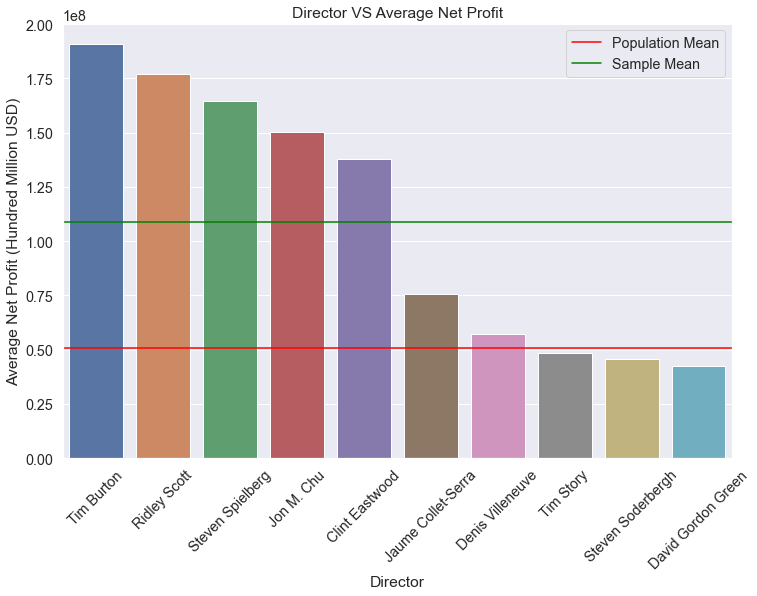

In [34]:
sns.set(rc={
    'figure.figsize':(12,8)
    })
sns.set(font_scale=1.3)
director_plot = sns.barplot(data=director_AGG, x='director', y='mean_net_profit')
director_plot.set(xlabel='Director', ylabel='Average Net Profit (Hundred Million USD)', title='Director VS Average Net Profit')
director_plot.set_xticklabels(labels=director_AGG.director, rotation=45);
director_plot.axhline(y = population_mean, color='red', label='Population Mean') 
director_plot.axhline(y = director_AGG.mean_net_profit.mean(), color='green', label='Sample Mean')
director_plot.legend()

The Seaborn graph that we created is a bar plot of the t-test statistic for a sample of mean net profit data.

The purpose of the t-test is to determine whether the mean net profit of a group of directors is significantly different from the population mean. The t-test statistic represents the difference between the sample mean and the population mean, standardized by the sample standard deviation and the sample size.

The bar plot visualizes the value of the t-test statistic. If the t-test statistic is greater than zero, it indicates that the sample mean is greater than the population mean. Conversely, if the t-test statistic is less than zero, it indicates that the sample mean is less than the population mean.

## Writer


Aggregated SQL query

Top 10 writers with highest mean_net_profit with num_movies greater than 5 Ordered by highest mean_net_profit descending

In [ ]:
#More code!
writer_AGG = pd.read_sql("""
SELECT pe.primary_name as writer, AVG(mob.worldwide_gross - mob.production_budget) as mean_net_profit, COUNT(pe.primary_name) as num_movies
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'writer'
GROUP BY pe.primary_name
HAVING num_movies > 5
ORDER BY mean_net_profit DESC
LIMIT 10
;
""", conn)
writer_AGG

,writer,mean_net_profit,num_movies
0,Jack Kirby,6.235416e+08,13
1,Stephen McFeely,6.037486e+08,7
2,Christopher Markus,6.037486e+08,7
3,Stan Lee,5.967671e+08,16
4,Linda Woolverton,5.860717e+08,7
5,Rick Jaffa,4.822119e+08,6
6,Amanda Silver,4.822119e+08,6
7,Jeff Pinkner,3.706335e+08,6
8,Jonathan Aibel,2.590552e+08,6
9,Glenn Berger,2.590552e+08,6


We're using matplotlib to create a bar graph and visualize our sample population data for better insights

<AxesSubplot:xlabel='writer'>

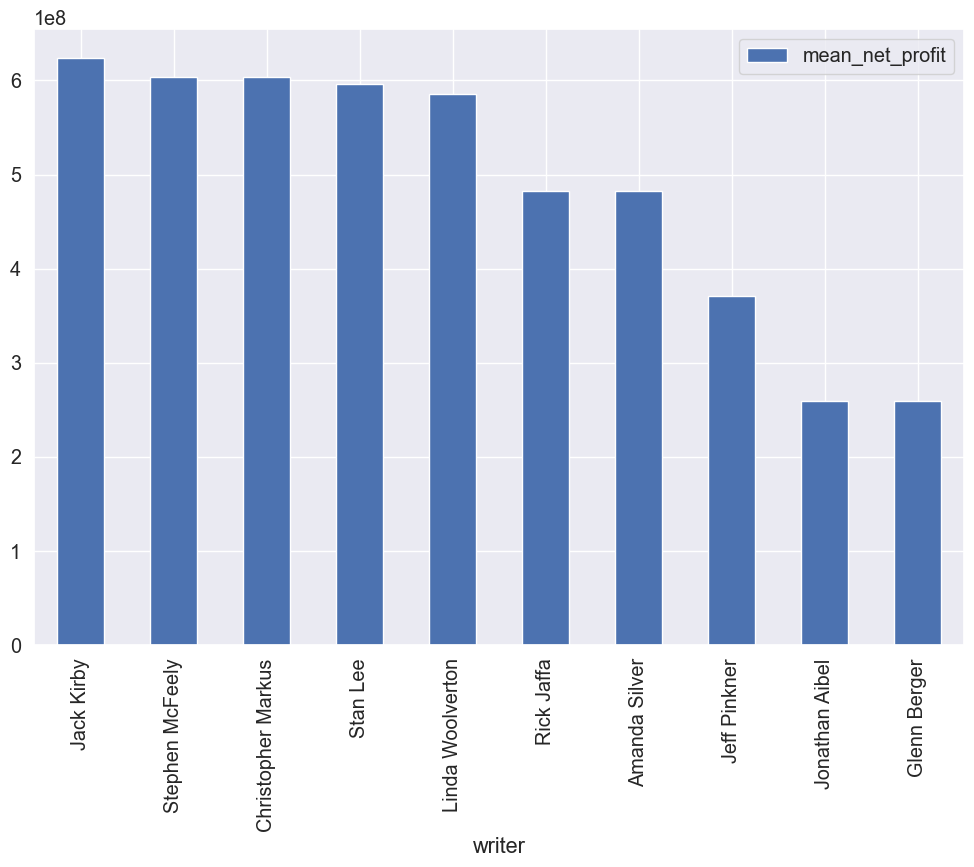

In [ ]:
writer_AGG.plot.bar(x='writer', y='mean_net_profit')

Disaggregated SQL query 2 categories

Writer
net_profit

In [ ]:
writer = pd.read_sql("""
SELECT pe.primary_name as writer, (mob.worldwide_gross - mob.production_budget) as net_profit
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'writer'
;
""", conn)
writer

,writer,net_profit
0,Madhan Karky,-700000
1,Sean Macaulay,22060480
2,Simon Kelton,22060480
3,Leonard Hartman,-26762748
4,Deborah Kaplan,13618920
...,...,...
4349,Emil B. Garuba,-625000
4350,Mariam Nwaringa,-625000
4351,Chijioke Ononiwu,-625000
4352,Farzaneh Fathi,-30147513


Our goal is to gain a deeper understanding of the statistics underlying our sample population, with a particular focus on identifying any significant differences between two groups, namely the writers and mean net profits. We aim to test our hypothesis that writers make a significantly higher net profit than the population mean, while rejecting the null hypothesis that they do not.

Hypothesis: (writer) makes significantly more net profit than our population mean.

Null Hypothesis: (writer) does not make significantly more net profit than our population mean.

In [ ]:
sample_mean = writer_AGG['mean_net_profit'].mean()
sample_variance = ((writer_AGG['mean_net_profit'] - sample_mean)**2).sum()/(len(writer_AGG)-1)
sample_std = math.sqrt(sample_variance)
population_mean = writer['net_profit'].mean()

#t_test = (sample_mean - population_mean) / (sample_std/math.sqrt(10))
t_test = ttest_1samp(writer_AGG['mean_net_profit'], population_mean)
print("Sample mean of mean net profit:", sample_mean)
print("Sample standard deviation of mean net profit:", sample_std)
print("population mean of mean net profit:", population_mean)
print("t-test statistic:", t_test)

NameError: name 'math' is not defined

The t-test statistic of 8.347 indicates that the difference between the sample mean of mean net profit (486704518.06) and the population mean of mean net profit (107977945.74) is statistically significant. The p-value of 1.573882281540297e-05, which is less than the commonly used significance level of 0.05, also supports this conclusion.

Therefore, we can reject the null hypothesis and conclude that the top 10 writers do make significantly more net profit than the population mean. However, it is important to note that this conclusion is based on the specific sample and population studied and may not be generalizable to other populations or contexts. Further research and analysis may be necessary to confirm and extend this finding.